## Conditioning

In [122]:
import numpy as np
from scipy import linalg as la
import sympy as sy
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from sympy.utilities.lambdify import lambdify
from scipy.sparse import csr_matrix


### Problem 1

In [3]:
def condition_number(A):
    '''
    This function computes the condition number of a matrix A.
    κ(A) = ||A|| ||A**(-1)||.
    The condition number is an upper bound on the condition number for
    many of the common problems associated with the matrix, such as solving Ax = b.
    
    κ(A) = σ_max / σ_min
    
    Where σ is a singular value of A
    
    '''
    
    # Compute the singular values from the Singular Value Decomposition Algo
    σ_all = la.svdvals(A)
    # Extract the 2-norm
    σ_max = np.max(σ_all)
    σ_min = np.min(σ_all)
    
    print("σmin is", σ_min)
    # Set κ = inf if the matrix is not invertible
    if σ_min <= 1e-6:
        κ = 1e200
    else:
        κ = σ_max / σ_min
    
    print("Computed κ =", κ)
    print("Condition number from np algorithm = ", np.linalg.cond(A))
    
    
    return κ

In [4]:
# Run the function
A = np.matrix([[2.4, 4.5, 6.3],
              [3.2, 9., -12.],
              [12, 3, 5.5]])
condition_number(A)

σmin is 4.982569068830737
Computed κ = 3.1402560982571415
Condition number from np algorithm =  3.1402560982571415


3.1402560982571415

In [5]:
## Check that two orthonormal matrices have a condition number of 1
# Generate an orthonormal matrices from A
Sing = np.matrix([[   1,    8,   50],
                  [   8,   64,  400],
                  [  50,  400, 2500]])

condition_number(Sing)


σmin is 5.284605007076471e-17
Computed κ = 1e+200
Condition number from np algorithm =  4.853721321773866e+19


1e+200

### The Wilkinson Polynomial

In [6]:
### Example
#The roots of w are 1, 2, ..., 20.
w_roots = np.arange(1, 21)
# Get the exact Wilkinson polynomial coefficients using SymPy.
x, i = sy.symbols('x i')
w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
w_coeffs = np.array(w.all_coeffs())
print(w_coeffs[:6])
# Perturb one of the coefficients very slightly.
h = np.zeros(21)
h[1]=1e-7
new_coeffs = w_coeffs - h
print(new_coeffs[:6])
# Use NumPy to compute the roots of the perturbed polynomial.
new_roots = np.roots(np.poly1d(new_coeffs))

# Sort the roots
w_roots = np.sort(w_roots)
new_roots = np.sort(new_roots)

# Estimate the absolute condition number in the infinity norm.
k = la.norm(new_roots - w_roots, np.inf) / la.norm(h, np.inf)
print(k)

# Estimate the relative condition number in the infinity norm.
k2 = k * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
print(k2)


[1 -210 20615 -1256850 53327946 -1672280820]
[1 -210.000000100000 20615 -1256850 53327946 -1672280820]
28262385.815815903
1.95063591933113e+25


### Problem 2

Absolute condition number  4.735319269814631
Relative condition number  3.26815676789187e+18


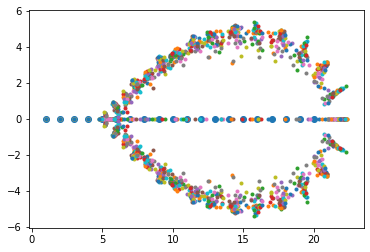

In [7]:
w_roots = np.arange(1, 21)
x, i = sy.symbols('x i')    
# Sort the roots
w_roots = np.sort(w_roots)

# Randomly perturb the true coefficients of the Wilkinson polynomial
w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
w_coeffs = np.array(w.all_coeffs())
    
plt.scatter(w_roots, np.zeros((20)))
#plt.xlabel('Real Axis')
#plt.ylabel('Imaginary Axis')

compabs = np.empty(())
comrel = np.empty(())

for i in range(100):
    
    # Perturb one of the coefficients very slightly.
    h = np.zeros(21)
    for j in range(21):
        h[j] = np.random.normal(1, 10**(-10))
    new_coeffs = w_coeffs * h

    # Use NumPy to compute the roots of the perturbed polynomial.
    new_roots = np.roots(np.poly1d(new_coeffs))

    # Sort the roots
    new_roots = np.sort(new_roots)
    #print(new_roots)
    new_X = [x.real for x in new_roots]
    new_Y = [x.imag for x in new_roots]
    
    plt.scatter(new_X,new_Y, marker=".")

    # Estimate the absolute condition number in the infinity norm.
    k = la.norm(new_roots - w_roots, np.inf) / la.norm(h, np.inf)
    compabs = np.append(compabs, k)
    
    # Estimate the relative condition number in the infinity norm.
    k2 = k * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
    comrel = np.append(comrel, k2)
    
print("Absolute condition number ", np.mean(compabs))
print("Relative condition number ", np.mean(comrel))

In [8]:
np.random.normal(1, 10**(-10))

1.0000000000532365

### Calculating Eigenvalues

### Problem 3

In [9]:
def condition_eigen(A):
    
    # Define the perturbation
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    Ab = A+H
    
    # Compute the eigenvalues of both A and its perturbation
    wA, vA = la.eig(A)
    wAb, vAb = la.eig(Ab)
    
    ## Condition number 
    # || λ - λbar ||
    khat = la.norm(wA - wAb, 2) / la.norm(H, 2)
    κ = la.norm(A, 2) / la.norm(wA) * khat

    return κ



In [10]:
condition_eigen(A)

0.6983290956147664

### Problem 4

In [24]:
def relative_cond(x_min, x_max, y_min, y_max, res):
    
    gridX = np.linspace(x_min, x_max, res)
    gridY = np.linspace(y_min, y_max, res)
    rel = np.zeros((res, res))

    for x in range(res):
        for y in range(res):
            A = np.matrix([[1, gridX[x]], [gridY[y], 1]])
            rel[x,y] = condition_eigen(A)
    
    return(rel)

In [25]:
matrix = relative_cond(-100, 100, -100, 100, 200)

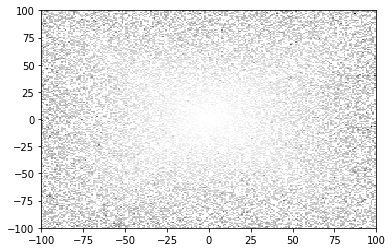

In [27]:
plt.pcolormesh(np.linspace(-100, 100, 200), np.linspace(-100, 100, 200), matrix, cmap='gray_r')


### Stability

In [31]:
computed_roots = np.sort(np.roots(np.poly1d(w_coeffs)))
print(computed_roots[:6])   
forward_error = la.norm(w_roots - computed_roots)
print(forward_error)
forward_error / la.norm(w_roots)
# Suggesting that np.roots() is a stable algorithm

[1.         2.         3.         3.99999998 5.00000067 5.99998925]
0.1581635111073643


0.0029523330552163516

### Least Squares

In [77]:

def stability_polyn(n):
    
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)

    # Normal Equation
    normal = la.inv(A.T @ A)@A.T@yk
    normaly = np.polyval(normal, np.linspace(0.0, 1.0, 100))
    
    # QR method
    Q, R = la.qr(A, mode='economic')
    meth_qr = la.solve_triangular(R, Q.T@yk)
    meth_qry = np.polyval(meth_qr, np.linspace(0.0, 1.0, 100))
    
    # Compute the forward errors
    error_normal = la.norm(yk - normaly)
    error_qr = la.norm(yk - meth_qry)
    
    print("Forward error from normal is ", error_normal)
    print("Forward error from qr method is ", error_qr)
    
    return xk, normaly, meth_qry

In [78]:
xk, normal, meth_qr = stability_polyn(14)

Forward error from normal is  396.94219827820694
Forward error from qr method is  4.568370945245598


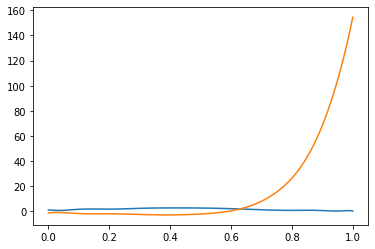

In [74]:
plt.plot(xk, meth_qr)
plt.plot(xk, -normal)
plt.show()

### Catastrophic Cancellation

In [123]:

def function_catastrophic(e):
    
    nvec = np.linspace(5, 50, 10)
    fall = np.empty(1)
    
    for n in range(10):
        Int = integrate(lambda x: x**nvec[n] * e**(x-1), 0, 1)[0]
        print("Int is ", Int)
        sub = (-1)**(nvec[n]) * sy.subfactorial(nvec[n]) + (-1)**(nvec[n]+1)* sy.factorial(n) / e
        sub
        print("sub is ", sub)
        forward = la.norm(Int - sub)
        fall = np.append(fall, forward)
    
    #plot
    plt.plot(nvec, fall)
    plt.set_yscale('log')
    plt.show
    
    return(fall)

In [117]:
#function_catastrophic(2)

Int is  0.1514901336521978
sub is  0.5 - 1.0*subfactorial(5.0)


AttributeError: 'Pow' object has no attribute 'sqrt'

In [121]:

Int = sy.integrate(lambda x: x**nvec[n] * e**(x-1), 0, 1)[


SympifyError: Sympify of expression 'could not parse '<function <lambda> at 0x6201c66a8>'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)